In [2]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define save path for model checkpoints
SAVE_PATH = "/content/drive/MyDrive/Vit_Models_Checkpoints"
os.makedirs(SAVE_PATH, exist_ok=True)


Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import time
from transformers import ViTForImageClassification
from torch.utils.data import random_split, DataLoader


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [5]:
# Define dataset path (update if needed)
dataset_path = "/content/drive/MyDrive/Dataset"

# Load dataset (each class in separate folder)
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Get class labels
class_labels = dataset.classes
num_classes = len(class_labels)
print(f"Class Labels: {class_labels}")


Class Labels: ['Acne', 'Athlete-foot', 'Contact Dermatitis', 'Eczema', 'Folliculitis', 'HFMD', 'Impetigo', 'Lupus', 'Milia', 'Psoriasis', 'Rosacea', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrh_Keratoses', 'Shingles', 'Tinea Ringworm Candidiasis', 'vitiligo']


In [6]:
# Define split sizes 80 traing ,20 % validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [8]:
# Load pre-trained ViT model with size mismatch handling
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=num_classes,
    ignore_mismatched_sizes=True  # ✅ Fix size mismatch error
)

# Freeze all layers except classifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only classifier layer
model.classifier.weight.requires_grad = True
model.classifier.bias.requires_grad = True

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([16]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([16, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)


In [12]:
num_epochs = 200
train_accuracies = []
val_accuracies = []
total_accuracies = []

for epoch in range(num_epochs):
    model.train()
    correct_train, total_train = 0, 0
    running_loss = 0.0
    start_time = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        running_loss += loss.item()

    train_accuracy = (correct_train / total_train) * 100
    train_accuracies.append(train_accuracy)

    # ===== Validation =====
    model.eval()
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = (correct_val / total_val) * 100
    val_accuracies.append(val_accuracy)

    # ===== Total Accuracy Calculation =====
    total_correct = correct_train + correct_val
    total_samples = total_train + total_val
    total_accuracy = (total_correct / total_samples) * 100
    total_accuracies.append(total_accuracy)

    end_time = time.time()

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Acc: {train_accuracy:.2f}% - "
          f"Val Acc: {val_accuracy:.2f}% - "
          f"Total Acc: {total_accuracy:.2f}% - "
          f"Time: {end_time - start_time:.2f}s")

# ===== Save Final Model After All Epochs =====
final_model_path = os.path.join(SAVE_PATH, "Vit(LL).pth")
torch.save(model.state_dict(), final_model_path)
print(f"\n✅ Training Completed. Final Model saved at: {final_model_path}")

# ===== Print Final Total Accuracy =====
print(f"\n📊 Final Total Accuracy After {num_epochs} Epochs: {total_accuracies[-1]:.2f}%")


Epoch [1/200] - Train Acc: 83.71% - Val Acc: 80.16% - Total Acc: 83.00% - Time: 56.19s
Epoch [2/200] - Train Acc: 83.91% - Val Acc: 81.09% - Total Acc: 83.34% - Time: 54.84s
Epoch [3/200] - Train Acc: 85.12% - Val Acc: 81.25% - Total Acc: 84.34% - Time: 54.91s
Epoch [4/200] - Train Acc: 85.55% - Val Acc: 82.03% - Total Acc: 84.84% - Time: 55.06s
Epoch [5/200] - Train Acc: 85.74% - Val Acc: 82.19% - Total Acc: 85.03% - Time: 55.34s
Epoch [6/200] - Train Acc: 86.80% - Val Acc: 82.66% - Total Acc: 85.97% - Time: 55.23s
Epoch [7/200] - Train Acc: 86.64% - Val Acc: 82.66% - Total Acc: 85.84% - Time: 54.80s
Epoch [8/200] - Train Acc: 87.46% - Val Acc: 82.66% - Total Acc: 86.50% - Time: 55.74s
Epoch [9/200] - Train Acc: 87.89% - Val Acc: 83.12% - Total Acc: 86.94% - Time: 55.35s
Epoch [10/200] - Train Acc: 88.59% - Val Acc: 83.28% - Total Acc: 87.53% - Time: 56.03s
Epoch [11/200] - Train Acc: 89.26% - Val Acc: 83.12% - Total Acc: 88.03% - Time: 55.41s
Epoch [12/200] - Train Acc: 89.38% - Val 

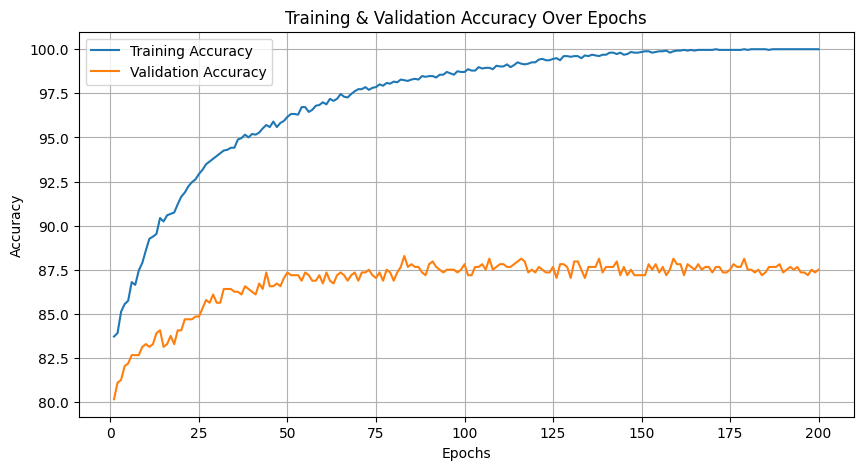

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()


In [21]:
from PIL import Image
import torch.nn.functional as F

# Load the saved model (last trained epoch)
latest_model_path = os.path.join(SAVE_PATH, "Vit(LL).pth")

# Load the trained model
model.load_state_dict(torch.load(latest_model_path, map_location=device))
model.eval()

# Function to preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Convert to RGB
    image = transform(image)  # Apply same transformations as dataset
    image = image.unsqueeze(0)  # Add batch dimension
    return image.to(device)

# Function to predict class
def predict(image_path):
    image = preprocess_image(image_path)
    with torch.no_grad():
        output = model(image).logits
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    print(f"Predicted Class: {class_labels[predicted_class]} (Confidence: {probabilities[0][predicted_class]:.4f})")

# Test with a sample image
test_image_path = "/content/drive/MyDrive/Dataset/Athlete-foot/FU-athlete-foot (5).jpeg"
#test_image_path = "/content/drive/MyDrive/Dataset/Scabies Lyme Disease and other Infestations and Bites/nosiebiting-insects-46.jpg"
#test_image_path = "/content/drive/MyDrive/Dataset/Eczema/0_29.jpg"
#test_image_path = "/content/drive/MyDrive/Dataset/Eczema/0_1.jpg"
#"C:\Users\Dell\Desktop\Dataset\Scabies Lyme Disease and other Infestations and Bites\nosiebiting-insects-46.jpg"

#test_image_path = "/content/drive/MyDrive/Dataset/Folliculitis/f1_aug_0.jpg"  # Change this path
#"C:\Users\Dell\Desktop\Dataset\Eczema\0_1.jpg"
predict(test_image_path)


<ipython-input-21-668dd53ba6ed>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(latest_model_path, map_location=device))


Predicted Class: Athlete-foot (Confidence: 1.0000)
